In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Data Pre-processing

In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 

In [4]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [5]:
# Parameters
num_snapshots = 100
sigma = 0.2
amplitude = 1.0
var = "u_relative"  # replace with your variable name if different

# Get spatial shape, dims, and coords from the reference dataset
template = ds_LR_reg[var]
dims = template.dims
coords = template.coords
H, W = template.shape[-2], template.shape[-1]

# Create coordinate arrays for the blob
y = np.linspace(-1, 1, H)
x = np.linspace(-1, 1, W)
X, Y = np.meshgrid(x, y)

# Generate 100 blobs
blobs = []
for _ in range(num_snapshots):
    x0 = np.random.uniform(-0.5, 0.5)
    y0 = np.random.uniform(-0.5, 0.5)
    blob = amplitude * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    blobs.append(blob)

# Stack into a 3D array
blob_array = np.stack(blobs, axis=0)

# Expand to match full dims of template, assuming time is first dim
# If your dataset uses another name for time, adjust accordingly
full_dims = (dims[0], dims[1], dims[2])  # e.g., ('time', 'yt_ocean', 'xt_ocean')
new_coords = {
    dims[0]: coords[dims[0]][:num_snapshots],
    dims[1]: coords[dims[1]],
    dims[2]: coords[dims[2]]
}

# Create new DataArray
blob_da = xr.DataArray(blob_array, dims=full_dims, coords=new_coords)

# Wrap into a Dataset under the specified variable name
blob_ds = xr.Dataset({var: blob_da})

In [6]:
ds_LR_blob = blob_ds
ds_HR_blob = blob_ds * 0.1

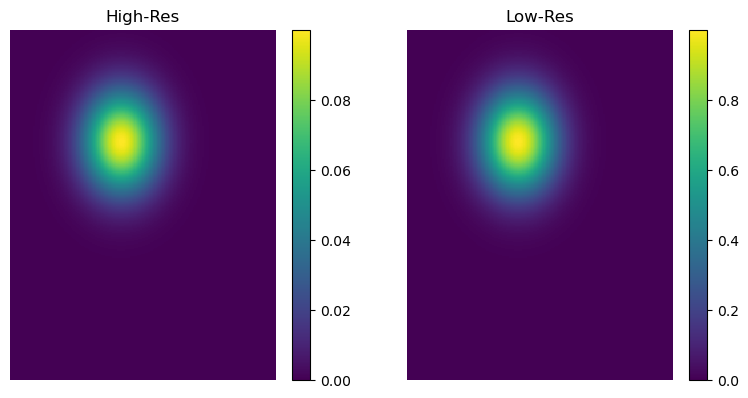

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_HR_blob.u_relative.isel(time=0))
axes[0].set_title("High-Res")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_LR_blob.u_relative.isel(time=0))
axes[1].set_title("Low-Res")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

# Case 1: Standardization

In [8]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32, normalization_type='standardization')

Training set size: 70
Validation set size: 15
Testing set size: 15


In [9]:
# Instantiate the model with the parameters
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [10]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_stand_dummy.pth',
            n_epochs=20) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 6.276e-01, Val Loss: 7.992e-01, Epoch Time: 38.58s
Model saved at epoch 1
Epoch 2, Train Loss: 5.735e-02, Val Loss: 6.087e-01, Epoch Time: 38.29s
Model saved at epoch 2
Epoch 3, Train Loss: 3.253e-02, Val Loss: 4.334e-01, Epoch Time: 37.87s
Model saved at epoch 3
Epoch 4, Train Loss: 2.896e-02, Val Loss: 3.178e-01, Epoch Time: 39.29s
Model saved at epoch 4
Epoch 5, Train Loss: 2.292e-02, Val Loss: 2.276e-01, Epoch Time: 38.75s
Model saved at epoch 5
Epoch 6, Train Loss: 1.636e-02, Val Loss: 1.696e-01, Epoch Time: 37.02s
Model saved at epoch 6
Epoch 7, Train Loss: 1.124e-02, Val Loss: 1.209e-01, Epoch Time: 36.64s
Model saved at epoch 7
Epoch 8, Train Loss: 7.706e-03, Val Loss: 7.365e-02, Epoch Time: 35.59s
Model saved at epoch 8
Epoch 9, Train Loss: 5.052e-03, Val Loss: 4.030e-02, Epoch Time: 35.99s
Model saved at epoch 9
Epoch 10, Train Loss: 2.991e-03, Val Loss: 1.308e-02, Epoch Time: 37.63s
Model saved at epoch 10
Epoch 11, Train Lo

In [11]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_stand_dummy.pth')
sr_pred

Loaded model parameters from ./model_UNet_stand_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-0.23673369, -0.25046846, -0.27194718, ..., -0.27023906,
         -0.23594247, -0.21319206],
        [-0.30137995, -0.33401522, -0.3648413 , ..., -0.3606872 ,
         -0.3257083 , -0.28642523],
        [-0.322762  , -0.3297427 , -0.37051082, ..., -0.36925876,
         -0.3623907 , -0.31884152],
        ...,
        [-0.32244924, -0.36080718, -0.37352428, ..., -0.37205976,
         -0.35029602, -0.29979277],
        [-0.31062254, -0.3346015 , -0.36114055, ..., -0.35078928,
         -0.3433915 , -0.28068683],
        [-0.23961097, -0.27686068, -0.2786984 , ..., -0.30645677,
         -0.248922  , -0.24178176]],

       [[-0.2367337 , -0.2504685 , -0.2719472 , ..., -0.27024612,
         -0.235951  , -0.21320039],
        [-0.3013799 , -0.33401522, -0.36484137, ..., -0.36070782,
         -0.3257306 , -0.28644145],
        [-0.322762  , -0.32974285, -0.37051082, ..., -0.36928308,
         -0.36241698, -0.31886297],
...
        [-0.32244924, -0.36080718, -0.37352428, ..., -0.3720598 ,
         -0.35029602, -0.29979277],
        [-0.31062254, -0.33460152, -0.36114055, ..., -0.35078928,
         -0.3433915 , -0.28068686],
        [-0.23961097, -0.27686068, -0.2786984 , ..., -0.30645677,
         -0.248922  , -0.24178177]],

       [[-0.2367287 , -0.25017858, -0.2717288 , ..., -0.2702461 ,
         -0.23595098, -0.21320038],
        [-0.30129722, -0.33357757, -0.36430392, ..., -0.36070782,
         -0.32573062, -0.28644142],
        [-0.3225131 , -0.32891798, -0.36964864, ..., -0.36928305,
         -0.36241695, -0.31886294],
        ...,
        [-0.32244924, -0.36080718, -0.37352428, ..., -0.37205976,
         -0.35029602, -0.29979277],
        [-0.31062254, -0.3346015 , -0.36114055, ..., -0.35078928,
         -0.3433915 , -0.28068683],
        [-0.23961097, -0.27686068, -0.2786984 , ..., -0.30645674,
         -0.248922  , -0.24178174]]], shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0182-06-05 12:00:00 ... 0182-07-05 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

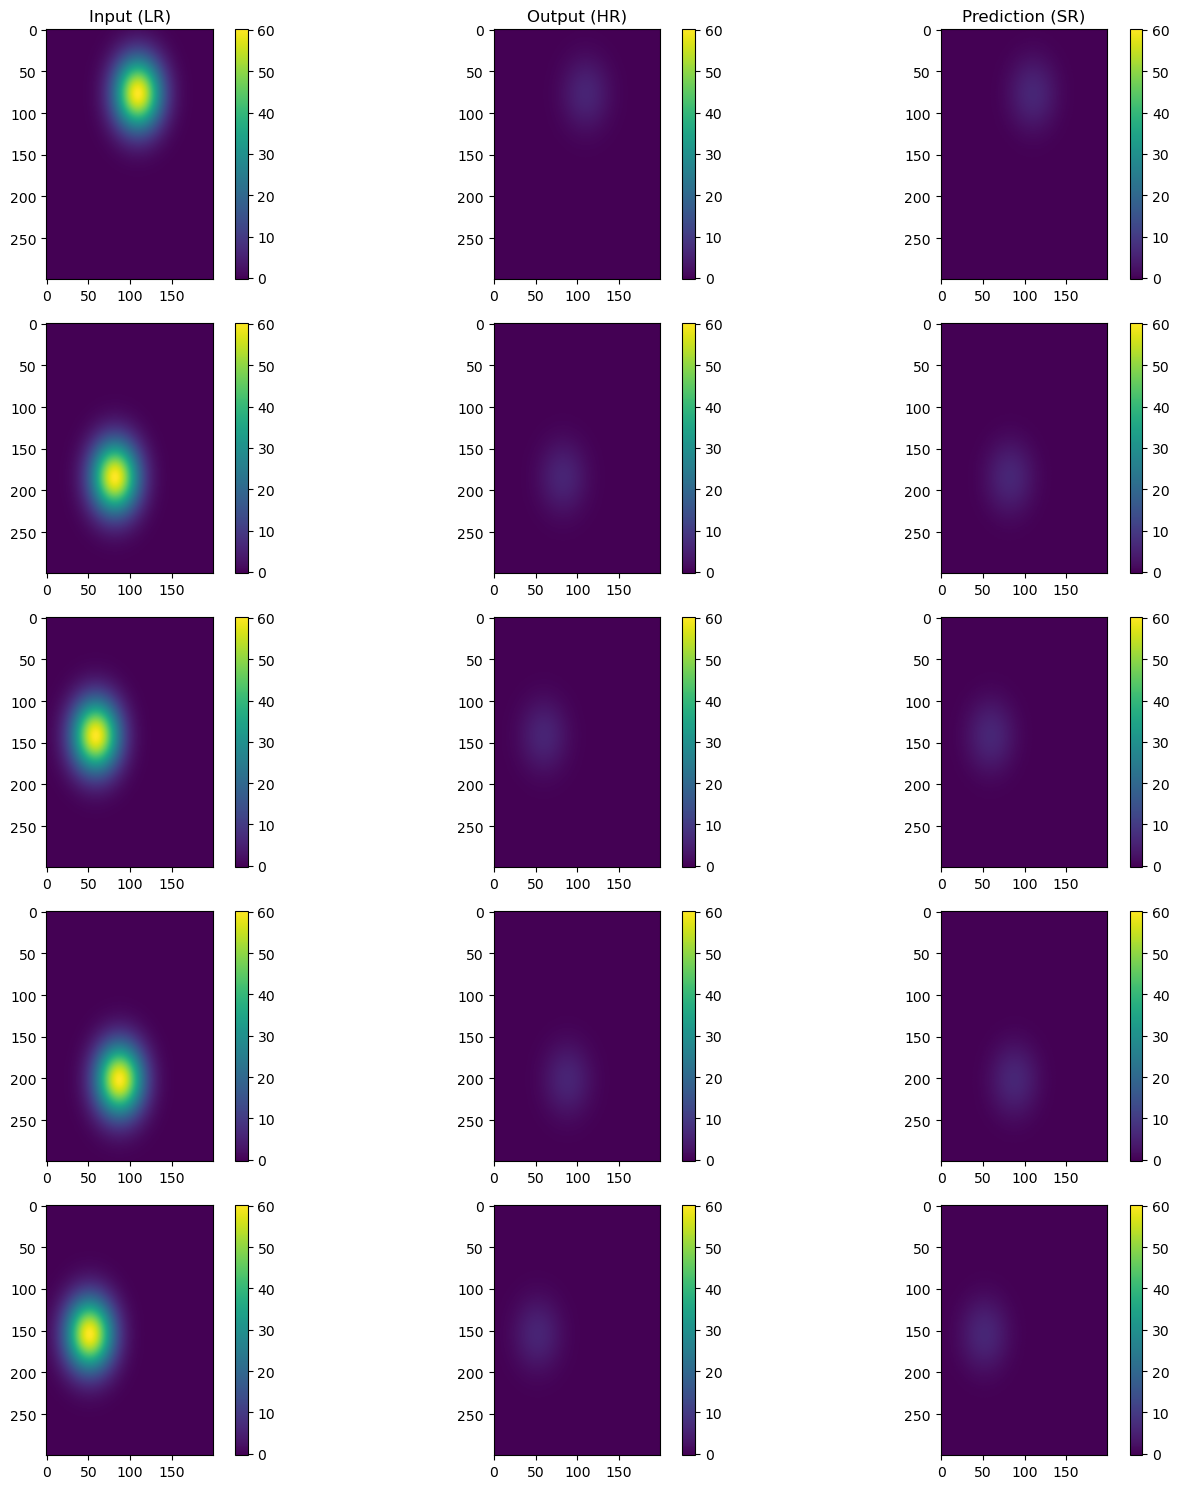

In [12]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

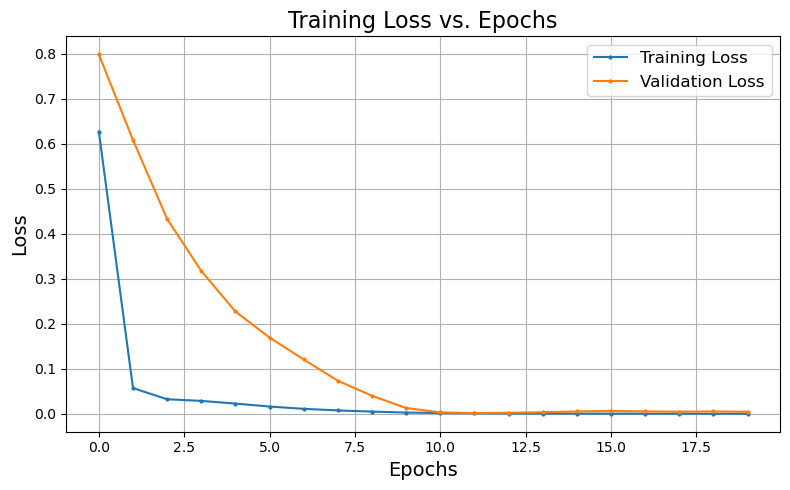

In [13]:
plot_train_val_losses(train_losses, val_losses)

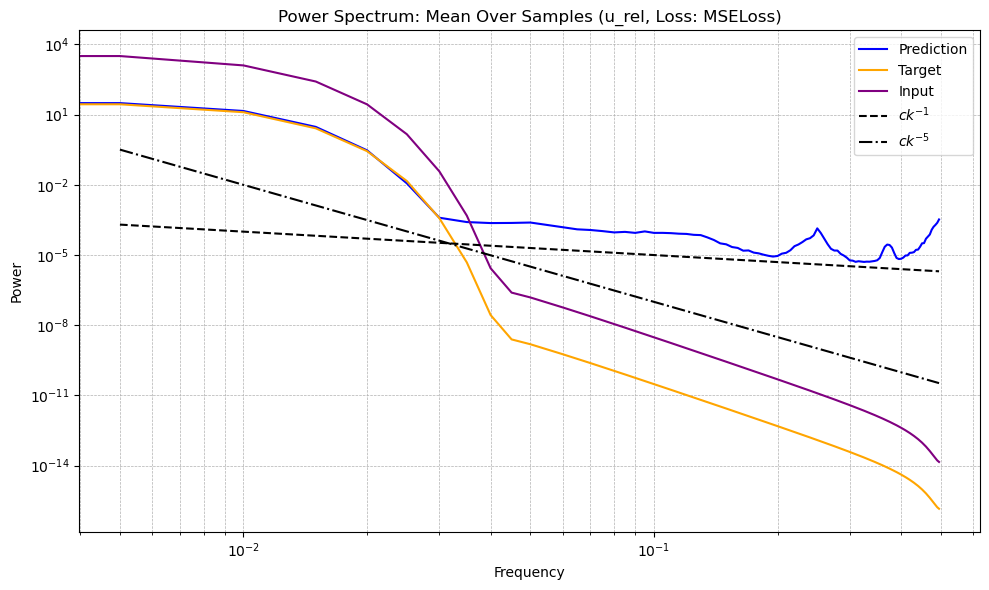

In [14]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

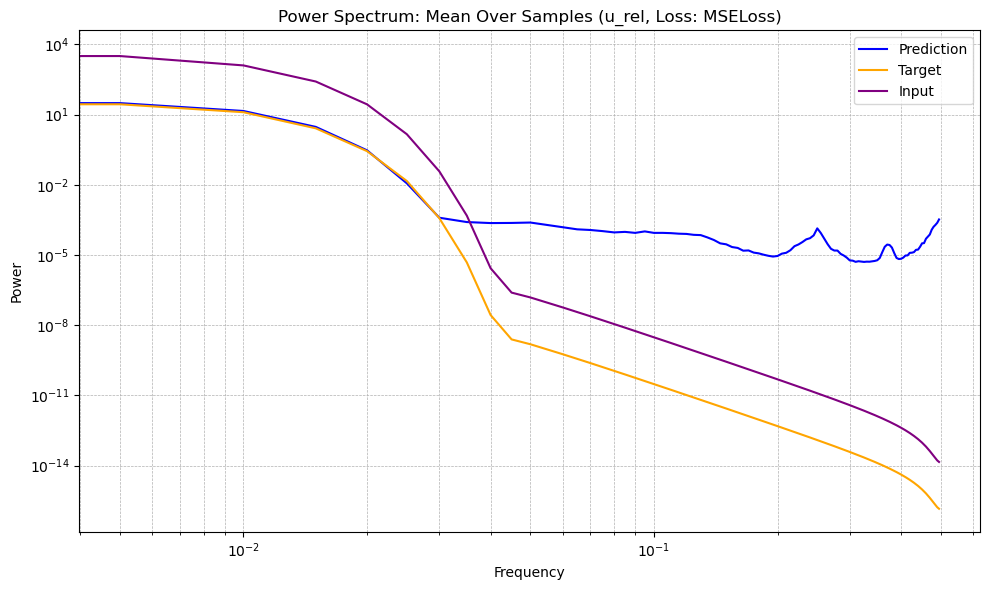

In [15]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

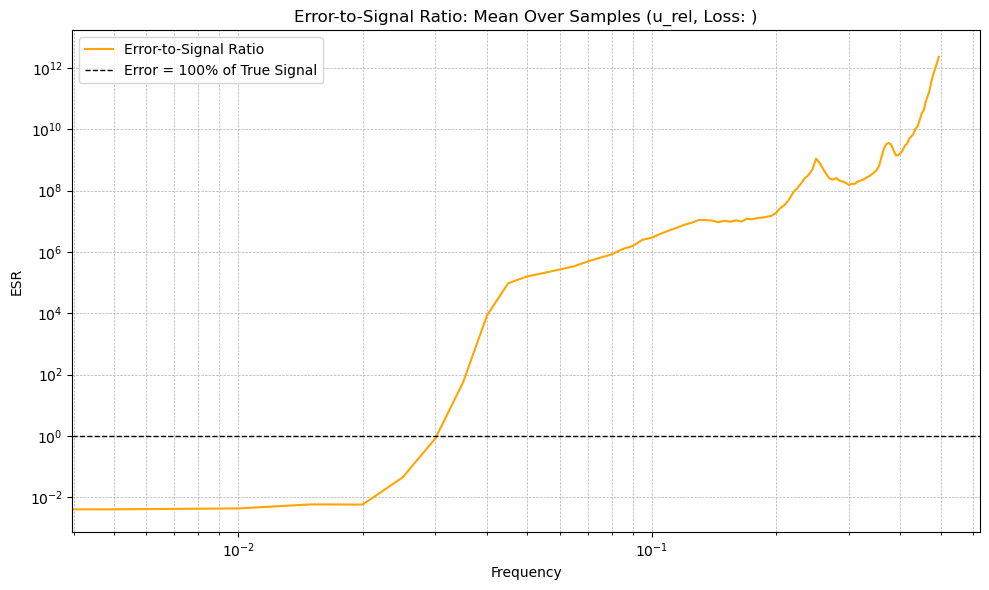

In [16]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="", alpha_label="", figsize=(10, 6))

In [17]:
mse(HR_test, sr_pred)

0.004801692292704762

In [18]:
pearson_corr(HR_test, sr_pred)

0.9997561249150463

In [19]:
r2_score(HR_test, sr_pred)

0.9951994922431174

# Case 2: Normalization

In [20]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32, normalization_type='normalization')

Training set size: 70
Validation set size: 15
Testing set size: 15


In [21]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_norm_dummy.pth',
            n_epochs=20) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 6.545e-01, Val Loss: 2.156e-02, Epoch Time: 36.02s
Model saved at epoch 1
Epoch 2, Train Loss: 4.070e-01, Val Loss: 3.095e-02, Epoch Time: 36.95s
Model saved at epoch 2
Epoch 3, Train Loss: 1.243e-01, Val Loss: 4.777e-02, Epoch Time: 36.37s
Model saved at epoch 3
Epoch 4, Train Loss: 2.289e-02, Val Loss: 4.021e-02, Epoch Time: 37.99s
Model saved at epoch 4
Epoch 5, Train Loss: 1.042e-02, Val Loss: 3.908e-02, Epoch Time: 37.50s
Model saved at epoch 5
Epoch 6, Train Loss: 4.140e-03, Val Loss: 4.515e-02, Epoch Time: 38.39s
Model saved at epoch 6
Epoch 7, Train Loss: 3.393e-03, Val Loss: 3.708e-02, Epoch Time: 37.53s
Model saved at epoch 7
Epoch 8, Train Loss: 2.939e-03, Val Loss: 2.228e-02, Epoch Time: 36.32s
Model saved at epoch 8
Epoch 9, Train Loss: 2.083e-03, Val Loss: 1.125e-02, Epoch Time: 37.40s
Model saved at epoch 9
Epoch 10, Train Loss: 1.154e-03, Val Loss: 5.374e-03, Epoch Time: 38.19s
Model saved at epoch 10
Epoch 11, Train Lo

In [22]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_norm_dummy.pth')
sr_pred

Loaded model parameters from ./model_UNet_norm_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-1.13590650e-01,  1.13650113e-02, -3.57930511e-02, ...,
          3.08248401e-03, -1.62332654e-02, -7.24756438e-03],
        [ 2.74708122e-03,  8.89559537e-02,  6.74341768e-02, ...,
          6.09721839e-02,  4.44990173e-02,  2.38718465e-02],
        [-3.30637991e-02,  2.83390582e-02, -9.12465155e-03, ...,
          1.48510933e-03,  2.26486474e-02, -2.60419846e-02],
        ...,
        [-4.61835414e-04,  2.14451551e-03,  2.51914933e-02, ...,
          2.52050757e-02,  1.63169168e-02,  1.86742507e-02],
        [-1.77169666e-02,  3.02362144e-02,  3.21298689e-02, ...,
          2.92941779e-02,  6.71526939e-02,  2.12106034e-02],
        [-8.40667486e-02, -2.47732513e-02, -4.59541194e-02, ...,
          5.53858280e-03, -3.23585793e-02, -2.14837361e-02]],

       [[-1.13589436e-01,  1.13663152e-02, -3.57930511e-02, ...,
          3.06910276e-03, -1.62351429e-02, -7.25319702e-03],
        [ 2.74716690e-03,  8.89550894e-02,  6.74330518e-02, ...,
          6.09329827e-02,  4.44810241e-02,  2.38688756e-02],
        [-3.30632925e-02,  2.83381194e-02, -9.12547112e-03, ...,
          1.46251917e-03,  2.26505548e-02, -2.60541961e-02],
...
          2.52053067e-02,  1.63176451e-02,  1.86740365e-02],
        [-1.77193657e-02,  3.02337855e-02,  3.21225971e-02, ...,
          2.92942673e-02,  6.71523362e-02,  2.12104954e-02],
        [-8.40657130e-02, -2.47787572e-02, -4.59620096e-02, ...,
          5.53976372e-03, -3.23581174e-02, -2.14833952e-02]],

       [[-1.13590941e-01,  1.13648102e-02, -3.57930511e-02, ...,
          3.08249891e-03, -1.62332654e-02, -7.24758487e-03],
        [ 2.74709985e-03,  8.89556706e-02,  6.74343407e-02, ...,
          6.09721914e-02,  4.44990322e-02,  2.38718316e-02],
        [-3.30639407e-02,  2.83387601e-02, -9.12477076e-03, ...,
          1.48510933e-03,  2.26486176e-02, -2.60419399e-02],
        ...,
        [-4.83933836e-05,  2.81420350e-03,  2.69343406e-02, ...,
          2.52053738e-02,  1.63178239e-02,  1.86739862e-02],
        [-1.76287964e-02,  3.03891152e-02,  3.28348950e-02, ...,
          2.92943269e-02,  6.71522915e-02,  2.12105140e-02],
        [-8.42661262e-02, -2.39197724e-02, -4.47520390e-02, ...,
          5.53998351e-03, -3.23579907e-02, -2.14833133e-02]]],
      shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0181-08-09 12:00:00 ... 0181-05-01 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

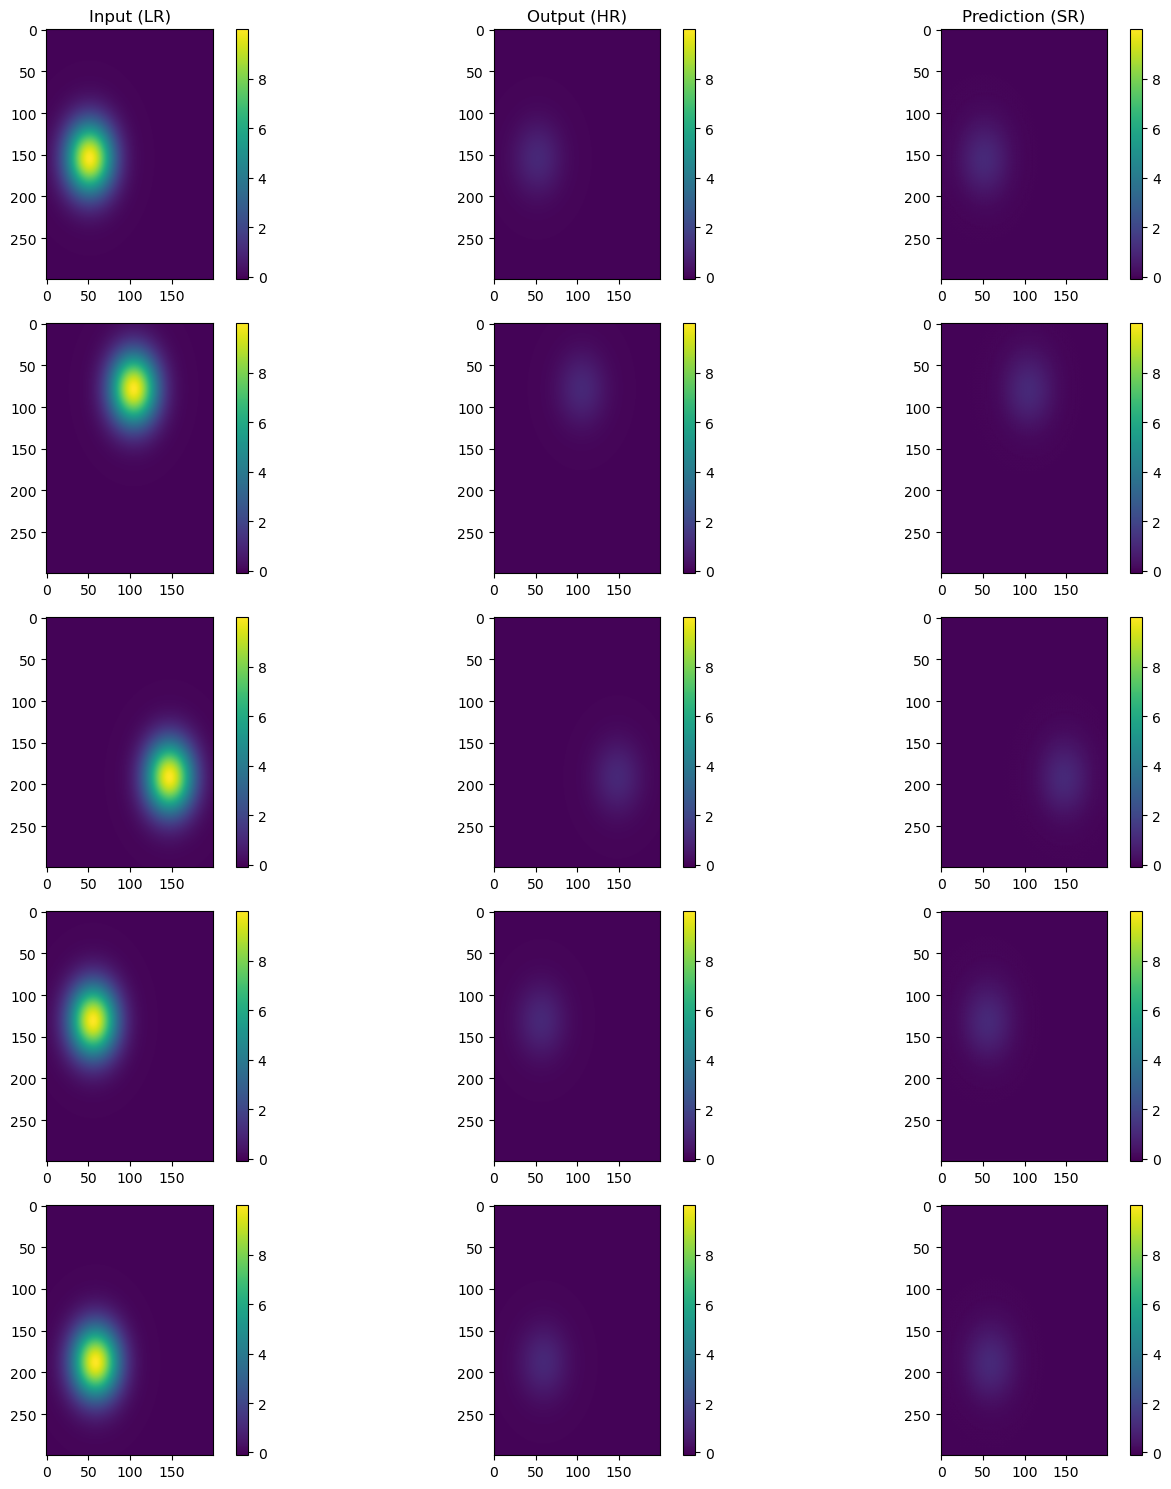

In [23]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

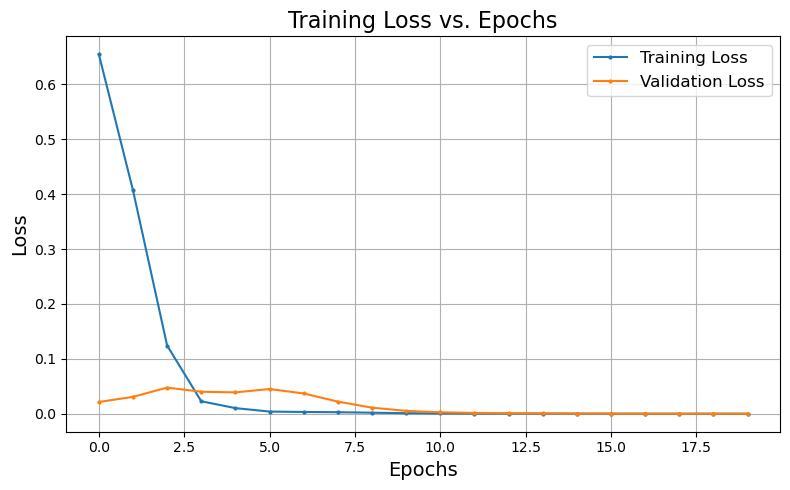

In [24]:
plot_train_val_losses(train_losses, val_losses)

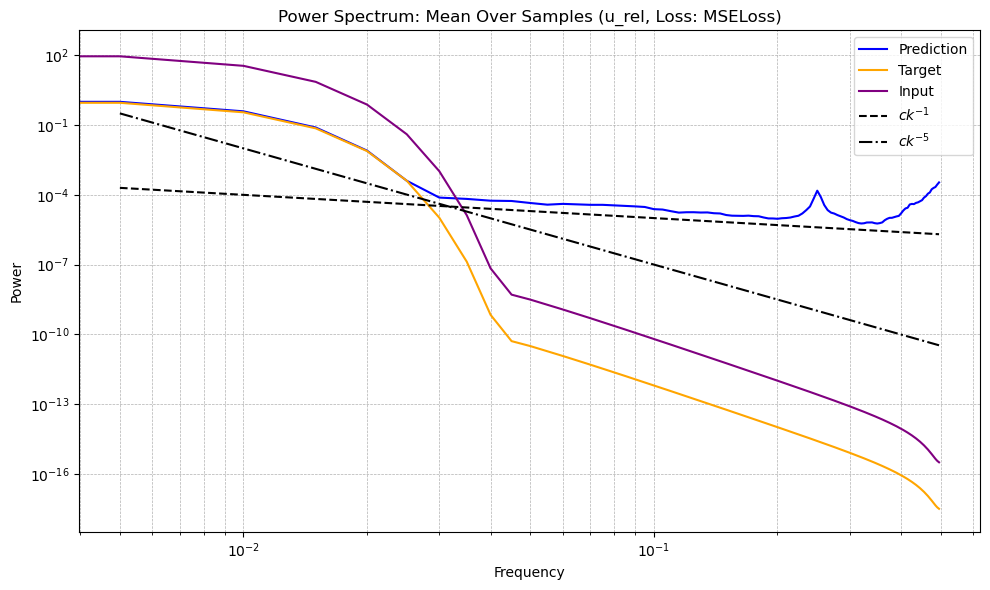

In [25]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

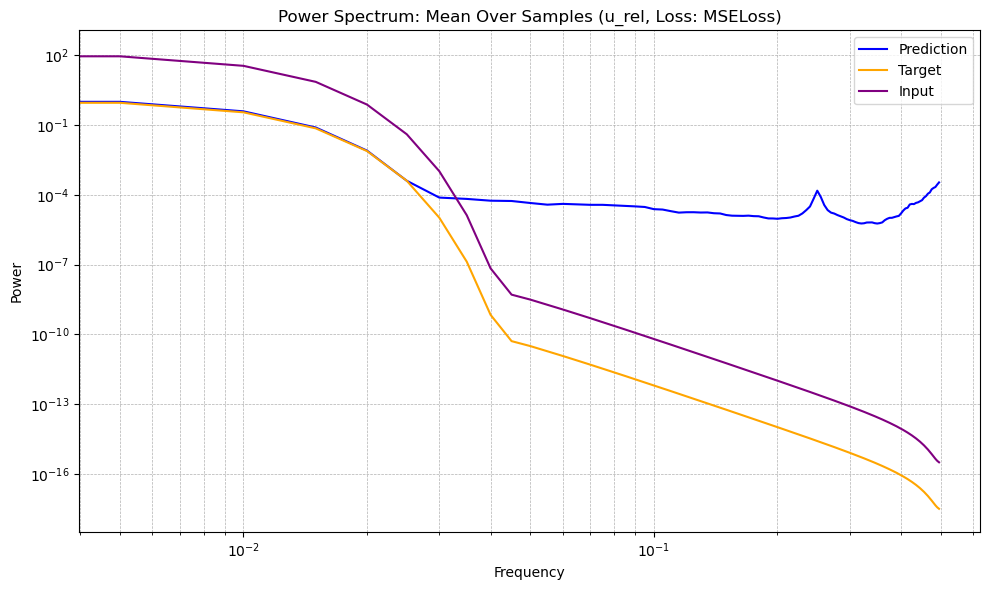

In [26]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

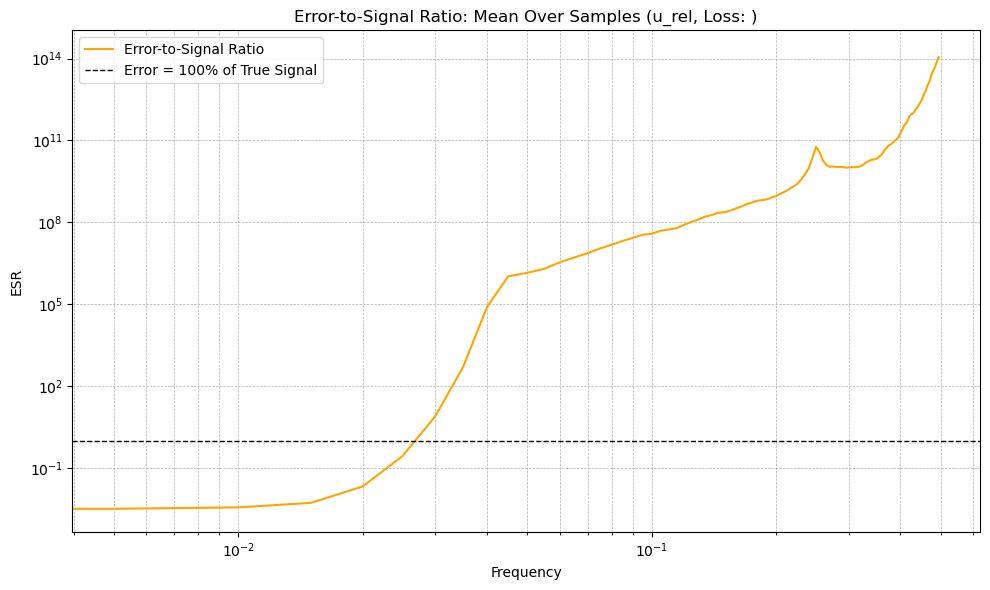

In [27]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="", alpha_label="", figsize=(10, 6))

In [28]:
mse(HR_test, sr_pred)

0.00022121200615713444

In [29]:
pearson_corr(HR_test, sr_pred)

0.9976007293918816

In [30]:
r2_score(HR_test, sr_pred)

0.9918936465385522

# Case 3: No Normalization

In [31]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32)

Training set size: 70
Validation set size: 15
Testing set size: 15


In [32]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_base_dummy.pth',
            n_epochs=20) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 1.838e-02, Val Loss: 1.084e-02, Epoch Time: 37.93s
Model saved at epoch 1
Epoch 2, Train Loss: 1.947e-03, Val Loss: 1.975e-02, Epoch Time: 36.77s
Model saved at epoch 2
Epoch 3, Train Loss: 1.562e-03, Val Loss: 2.939e-02, Epoch Time: 38.20s
Model saved at epoch 3
Epoch 4, Train Loss: 1.614e-03, Val Loss: 2.539e-02, Epoch Time: 37.63s
Model saved at epoch 4
Epoch 5, Train Loss: 6.200e-04, Val Loss: 1.493e-02, Epoch Time: 37.71s
Model saved at epoch 5
Epoch 6, Train Loss: 3.890e-04, Val Loss: 8.403e-03, Epoch Time: 38.97s
Model saved at epoch 6
Epoch 7, Train Loss: 3.525e-04, Val Loss: 5.438e-03, Epoch Time: 38.01s
Model saved at epoch 7
Epoch 8, Train Loss: 3.108e-04, Val Loss: 2.625e-03, Epoch Time: 37.32s
Model saved at epoch 8
Epoch 9, Train Loss: 1.652e-04, Val Loss: 1.561e-03, Epoch Time: 37.96s
Model saved at epoch 9
Epoch 10, Train Loss: 1.389e-04, Val Loss: 1.336e-03, Epoch Time: 37.58s
Model saved at epoch 10
Epoch 11, Train Lo

In [33]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_base_dummy.pth')
sr_pred

Loaded model parameters from ./model_UNet_base_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-0.07079475,  0.0247689 , -0.00516917, ...,  0.01087441,
          0.01781643, -0.04242454],
        [-0.00466423,  0.01705234,  0.00483441, ..., -0.00583804,
          0.02062067, -0.01137104],
        [-0.00344022,  0.01410222,  0.00507778, ...,  0.00401837,
          0.00479591, -0.00181846],
        ...,
        [-0.00083962,  0.01008358,  0.00836773, ...,  0.01208987,
         -0.00776499,  0.0111054 ],
        [-0.00904415, -0.0003673 ,  0.00251412, ..., -0.00356437,
          0.012868  ,  0.00556584],
        [-0.03689293,  0.00497279, -0.0094692 , ...,  0.00364189,
          0.00598095, -0.02431548]],

       [[-0.07079475,  0.0247689 , -0.00516918, ...,  0.01087441,
          0.01781641, -0.04242453],
        [-0.00466423,  0.01705234,  0.0048344 , ..., -0.00583804,
          0.02062065, -0.01137103],
        [-0.00344022,  0.01410221,  0.00507775, ...,  0.00401835,
          0.00479588, -0.00181844],
...
        [-0.0008369 ,  0.01006881,  0.00836459, ...,  0.01208985,
         -0.00776496,  0.01110539],
        [-0.00906324, -0.00039311,  0.00251345, ..., -0.00356439,
          0.01286807,  0.00556582],
        [-0.03688874,  0.00497777, -0.00946765, ...,  0.00364191,
          0.00598093, -0.0243155 ]],

       [[-0.07079464,  0.02476909, -0.00516905, ...,  0.01087441,
          0.01781642, -0.04242454],
        [-0.00466404,  0.01705246,  0.00483453, ..., -0.00583802,
          0.02062067, -0.01137104],
        [-0.00344022,  0.01410262,  0.00507787, ...,  0.00401835,
          0.00479588, -0.00181842],
        ...,
        [-0.00083708,  0.01006965,  0.00836465, ...,  0.01208992,
         -0.00776498,  0.01110544],
        [-0.00906229, -0.00039193,  0.00251341, ..., -0.00356437,
          0.01286799,  0.00556586],
        [-0.03688892,  0.00497744, -0.00946788, ...,  0.00364195,
          0.00598099, -0.02431544]]], shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0181-05-01 12:00:00 ... 0181-08-09 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

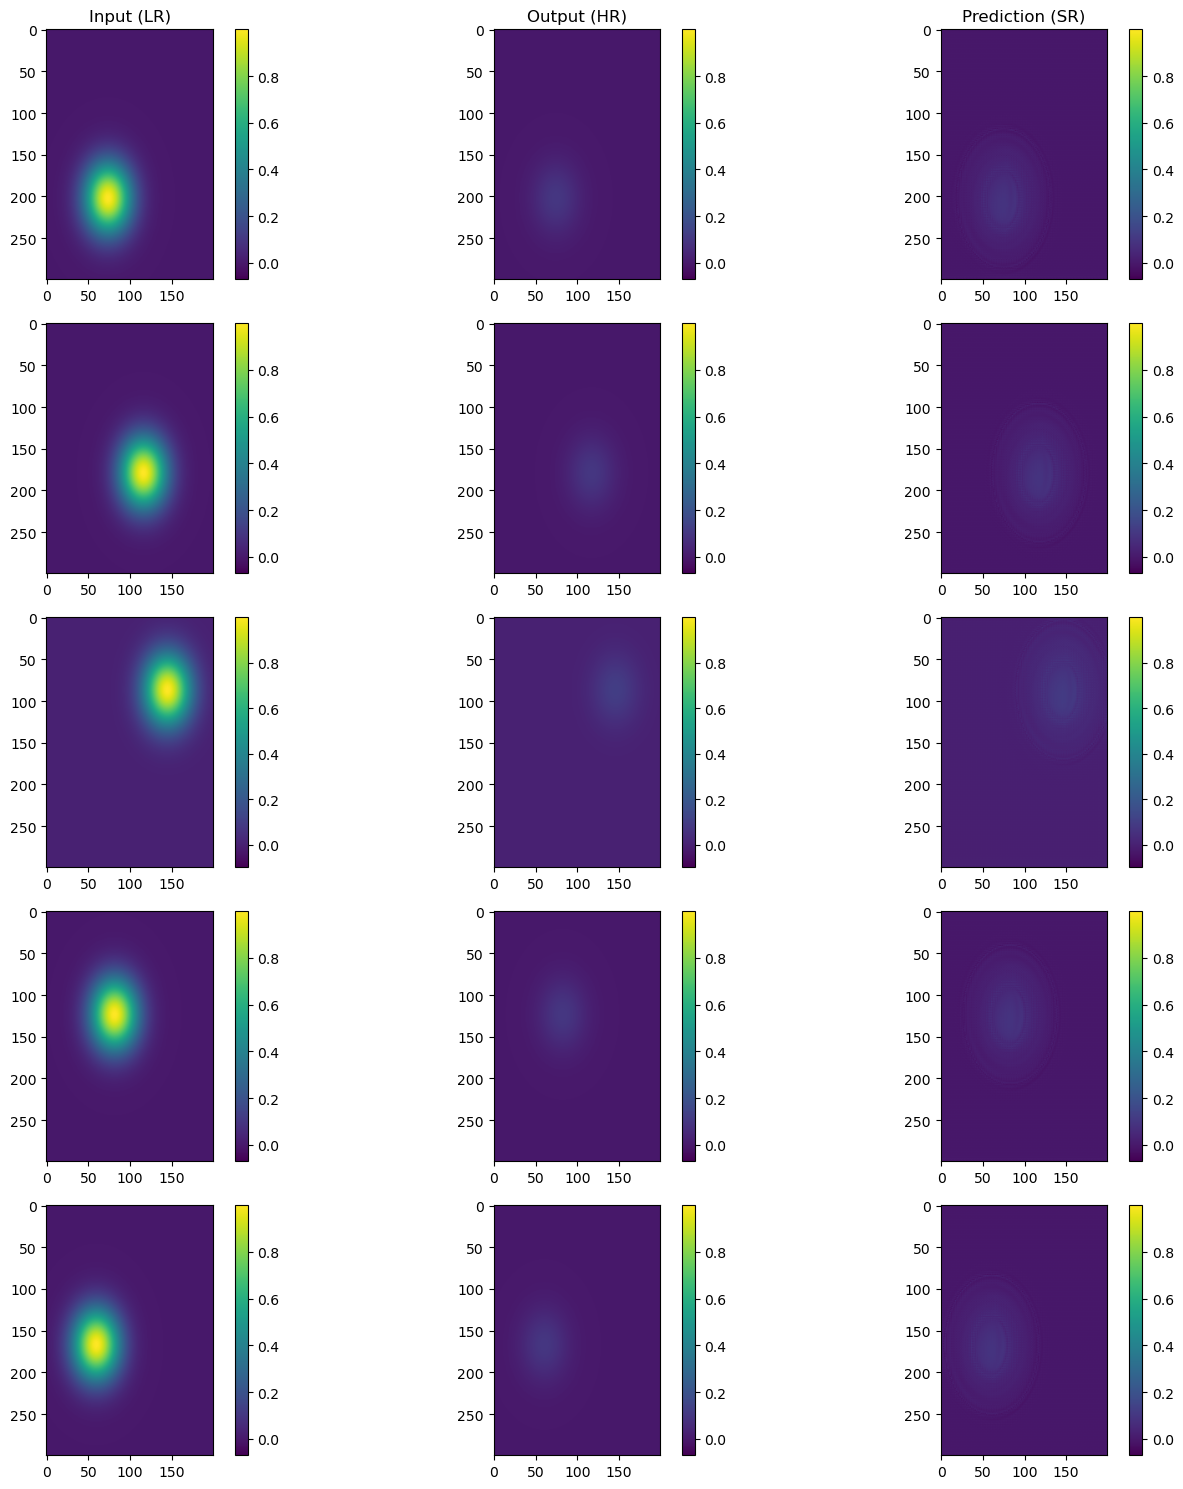

In [34]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

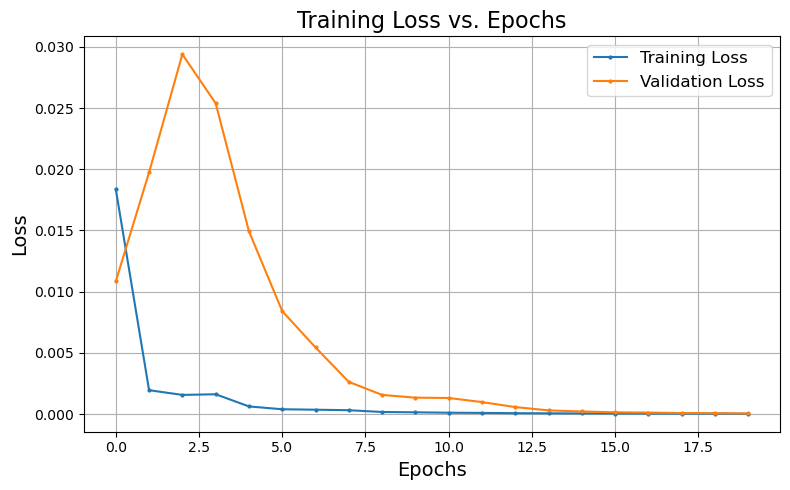

In [35]:
plot_train_val_losses(train_losses, val_losses)

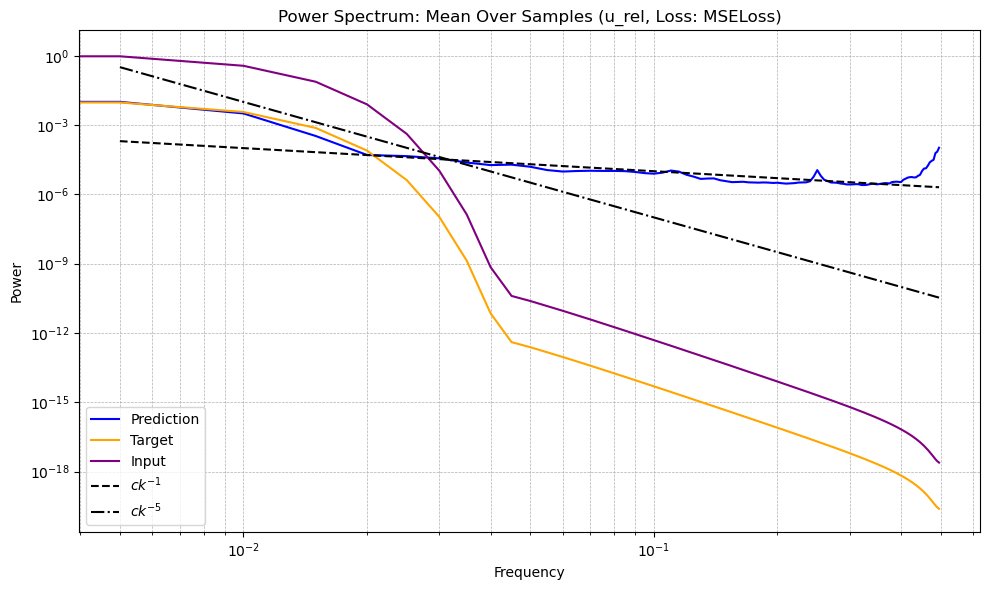

In [36]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

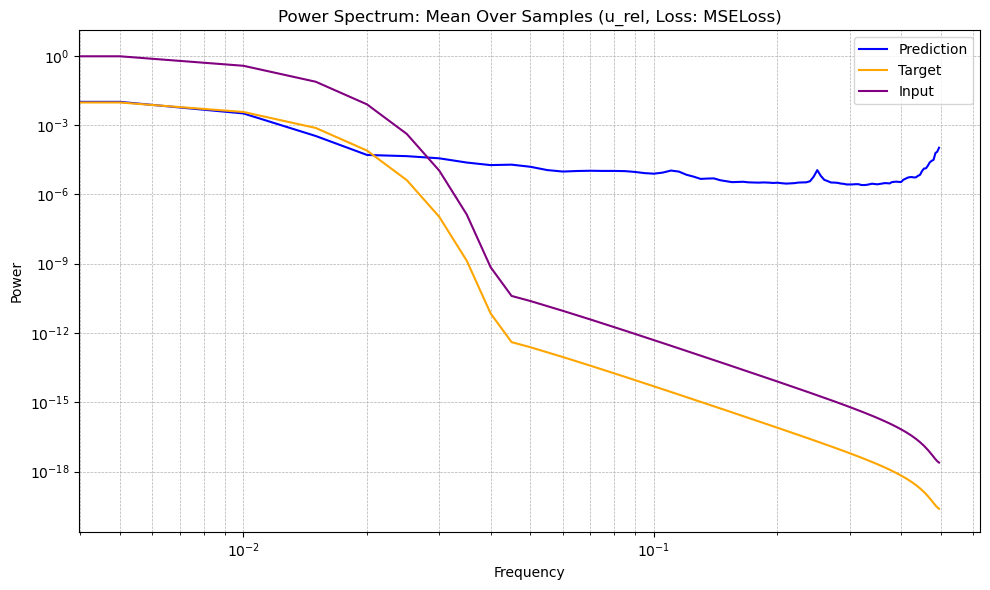

In [37]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

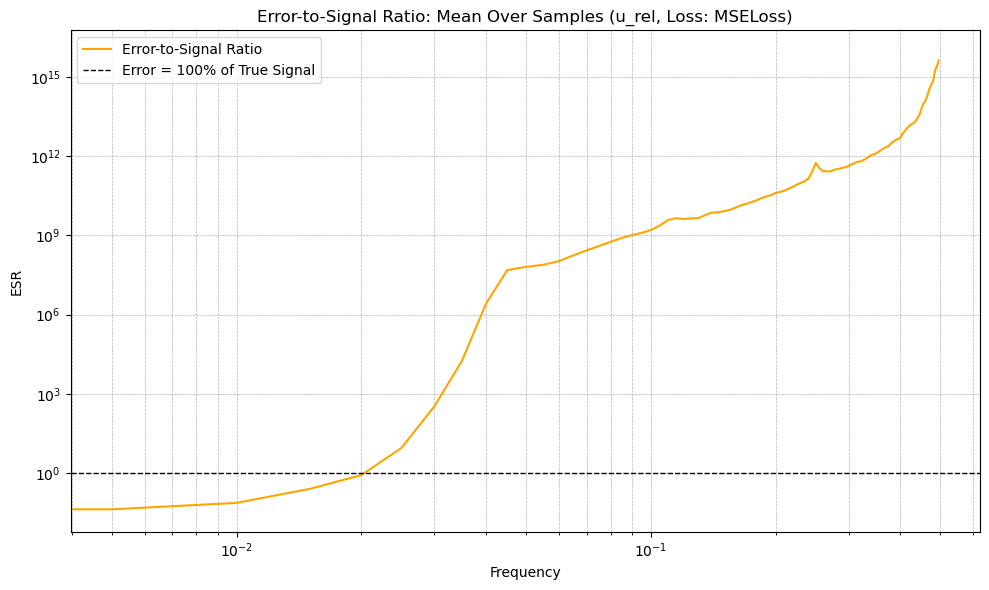

In [38]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [39]:
mse(HR_test, sr_pred)

4.6105877202637405e-05

In [40]:
pearson_corr(HR_test, sr_pred)

0.9309187436346249

In [41]:
r2_score(HR_test, sr_pred)

0.8310269679407754

# Case 4: No Normalization, CombinedLoss (alpha = 1)

In [42]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32)

Training set size: 70
Validation set size: 15
Testing set size: 15


In [43]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_UNet_alpha1_dummy.pth',
            n_epochs=20) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 1.023e-03, Val Loss: 1.031e-03, Epoch Time: 31.39s
Model saved at epoch 1
Epoch 2, Train Loss: 6.916e-04, Val Loss: 5.683e-04, Epoch Time: 38.68s
Model saved at epoch 2
Epoch 3, Train Loss: 3.251e-04, Val Loss: 6.177e-04, Epoch Time: 38.23s
Model saved at epoch 3
Epoch 4, Train Loss: 2.306e-04, Val Loss: 4.710e-04, Epoch Time: 39.39s
Model saved at epoch 4
Epoch 5, Train Loss: 1.547e-04, Val Loss: 4.135e-04, Epoch Time: 38.77s
Model saved at epoch 5
Epoch 6, Train Loss: 1.194e-04, Val Loss: 3.581e-04, Epoch Time: 37.94s
Model saved at epoch 6
Epoch 7, Train Loss: 7.780e-05, Val Loss: 3.447e-04, Epoch Time: 37.11s
Model saved at epoch 7
Epoch 8, Train Loss: 7.152e-05, Val Loss: 2.221e-04, Epoch Time: 38.18s
Model saved at epoch 8
Epoch 9, Train Loss: 4.736e-05, Val Loss: 1.623e-04, Epoch Time: 38.56s
Model saved at epoch 9
Epoch 10, Train Loss: 3.701e-05, Val Loss: 1.638e-04, Epoch Time: 38.85s
Model saved at epoch 10
Epoch 11, Train Lo

In [44]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_UNet_alpha1_dummy.pth')
sr_pred

Loaded model parameters from ./model_UNet_alpha1_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-0.0318323 ,  0.00406323, -0.00206362, ..., -0.00177997,
          0.02638904, -0.03049541],
        [ 0.00056171,  0.00901949, -0.00330558, ..., -0.000139  ,
          0.00593447, -0.00174568],
        [-0.00437815, -0.00946389, -0.00091705, ..., -0.00472535,
         -0.00596362, -0.00419994],
        ...,
        [ 0.00394085,  0.00703958, -0.00382907, ...,  0.00199328,
         -0.0007255 , -0.00074108],
        [ 0.00895005, -0.02068444,  0.0036695 , ..., -0.00806387,
         -0.00389619,  0.00019136],
        [-0.02483048,  0.0153737 , -0.00406135, ...,  0.00159192,
         -0.01785368, -0.00891872]],

       [[-0.03183232,  0.00406323, -0.00206364, ..., -0.00178032,
          0.02638824, -0.03049596],
        [ 0.00056172,  0.00901952, -0.00330561, ..., -0.00013908,
          0.00593444, -0.00174586],
        [-0.00437813, -0.00946386, -0.00091705, ..., -0.00472511,
         -0.00596356, -0.00419983],
...
        [ 0.00394086,  0.00703958, -0.00382907, ...,  0.00199317,
         -0.00072556, -0.00074106],
        [ 0.00895005, -0.02068447,  0.00366952, ..., -0.00806393,
         -0.00389604,  0.00019147],
        [-0.02483048,  0.01537368, -0.00406137, ...,  0.00159195,
         -0.01785368, -0.0089187 ]],

       [[-0.03183231,  0.00406323, -0.00206364, ..., -0.00178026,
          0.02638828, -0.03049596],
        [ 0.00056171,  0.00901951, -0.0033056 , ..., -0.00013906,
          0.00593444, -0.00174586],
        [-0.00437814, -0.00946389, -0.00091705, ..., -0.00472514,
         -0.00596353, -0.00419988],
        ...,
        [ 0.00394085,  0.00703957, -0.00382907, ...,  0.00199327,
         -0.0007255 , -0.00074107],
        [ 0.00895005, -0.02068444,  0.00366947, ..., -0.00806385,
         -0.00389618,  0.00019136],
        [-0.02483048,  0.0153737 , -0.00406136, ...,  0.00159191,
         -0.01785367, -0.00891873]]], shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0181-03-22 12:00:00 ... 0181-12-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

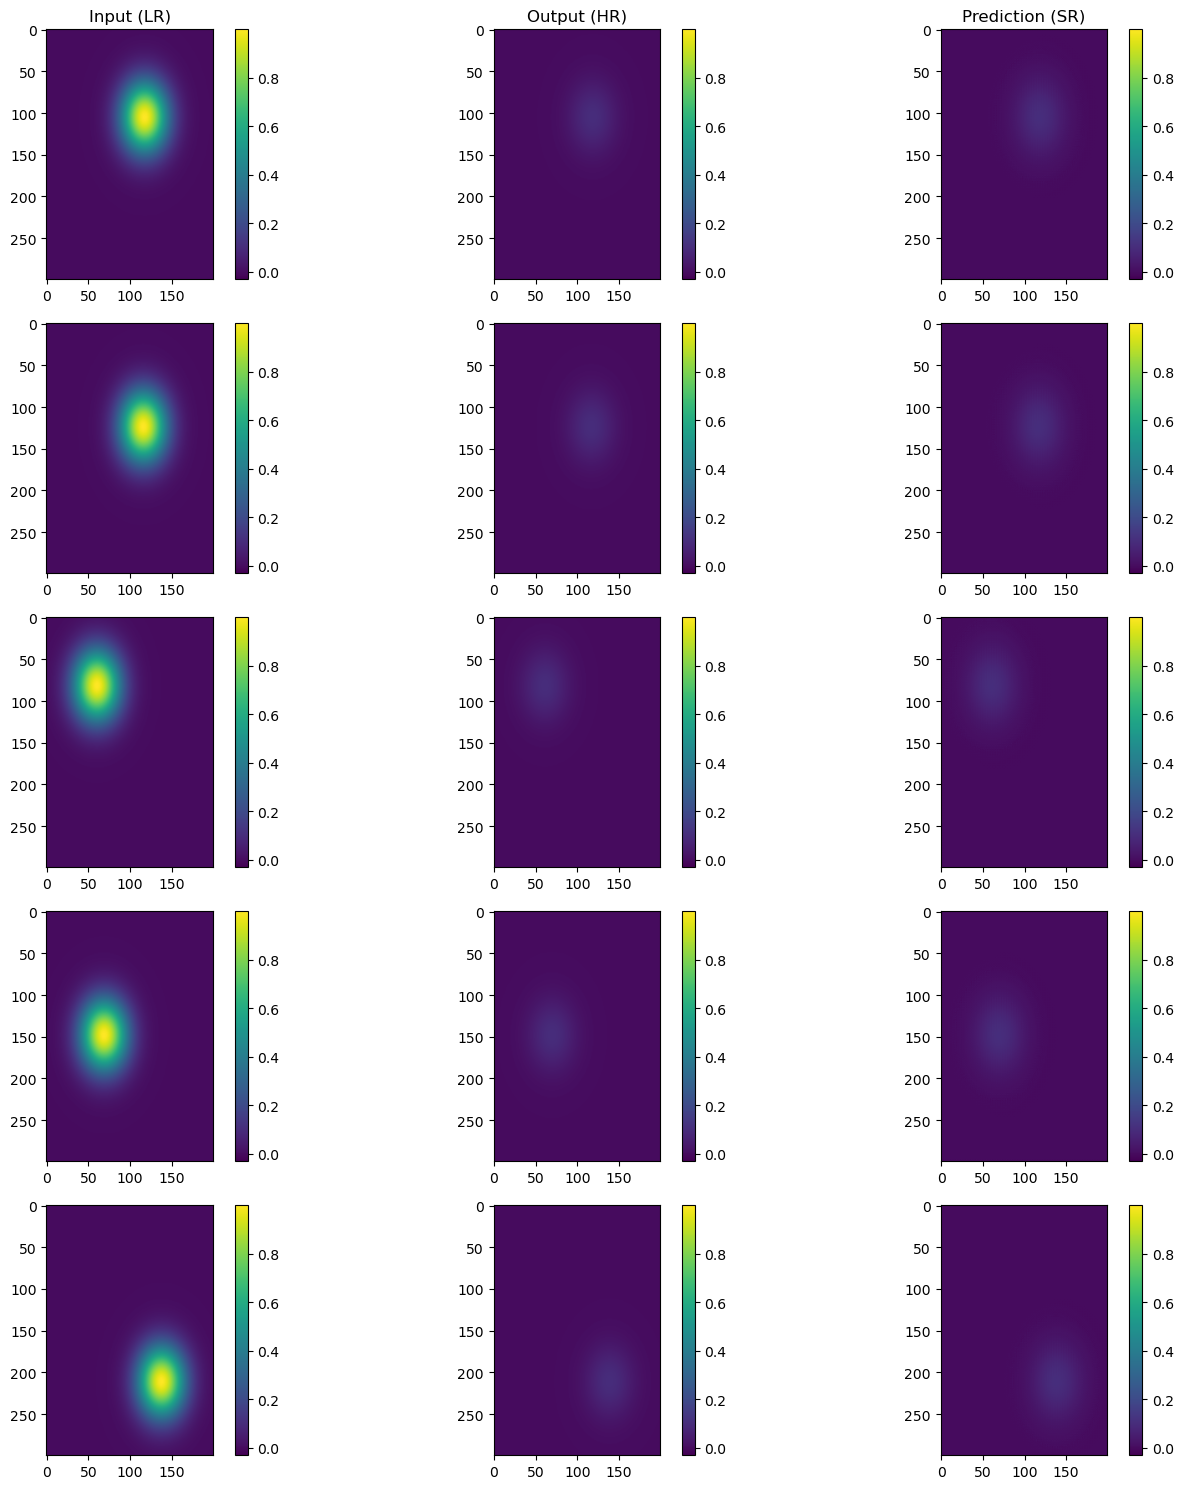

In [45]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

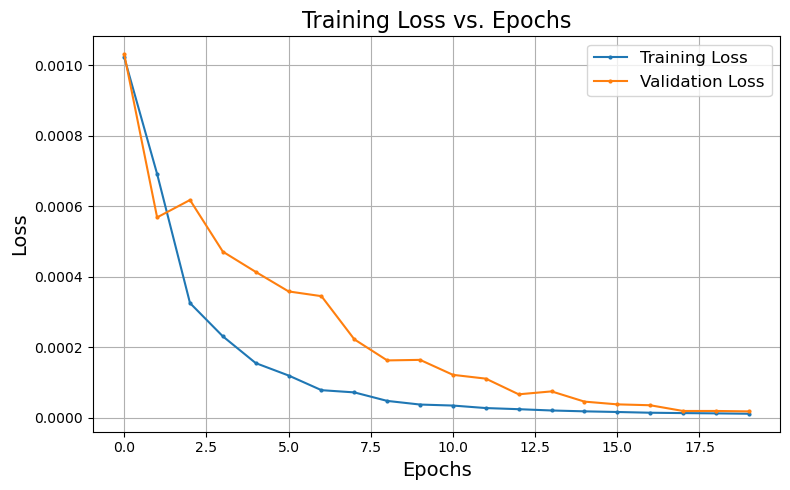

In [46]:
plot_train_val_losses(train_losses, val_losses)

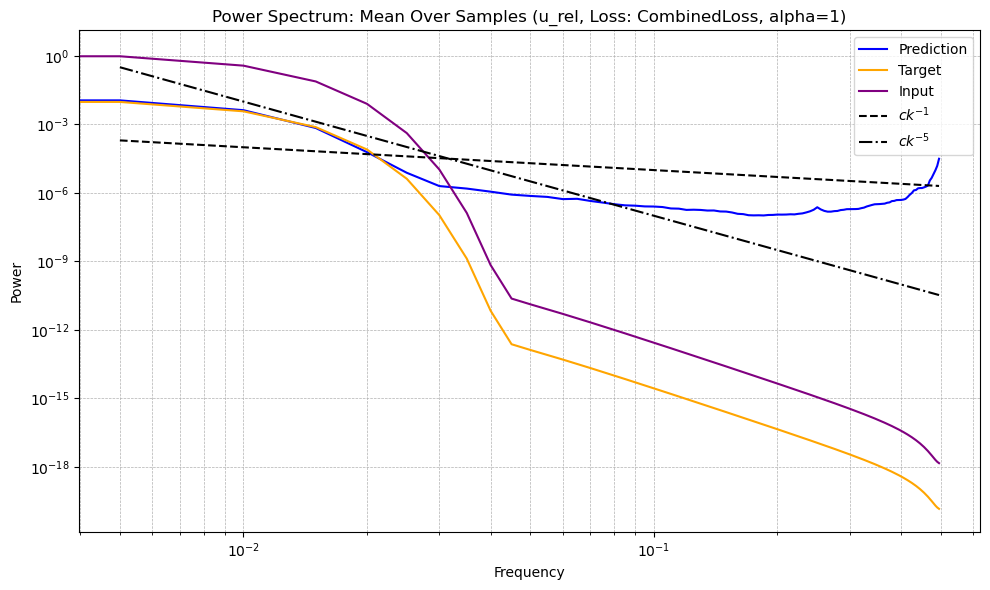

In [47]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

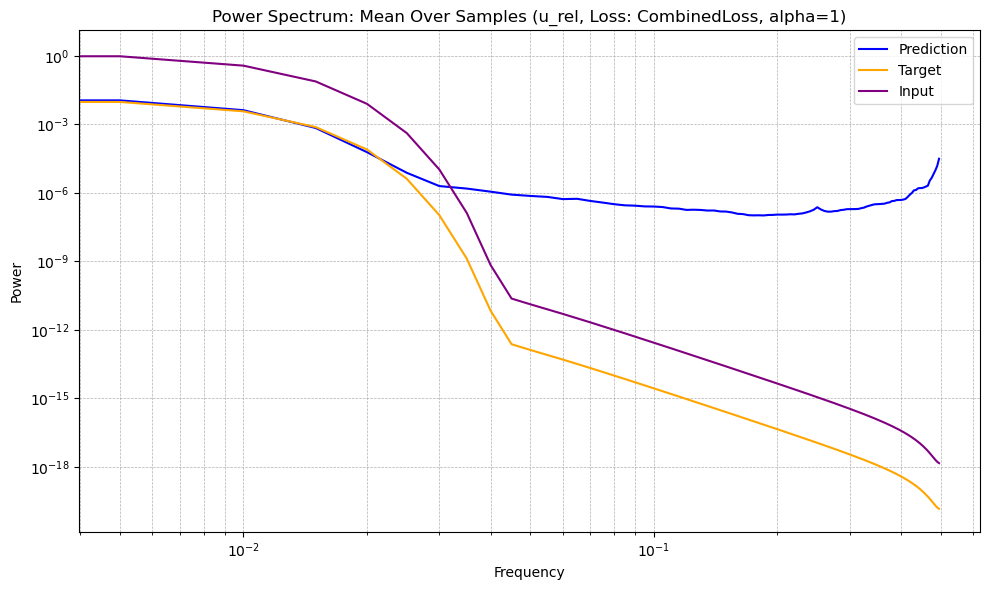

In [48]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6))

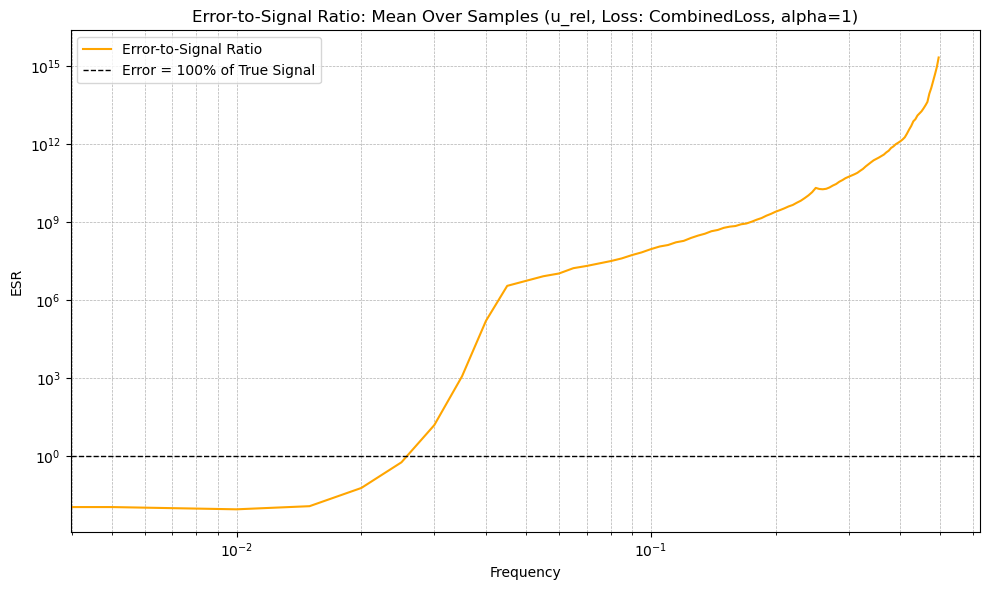

In [49]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6))

In [50]:
mse(HR_test, sr_pred)

8.113665373638972e-06

In [51]:
pearson_corr(HR_test, sr_pred)

0.9917782116070063

In [52]:
r2_score(HR_test, sr_pred)

0.9702621940798889